# How do logistic and linear regression differ?

 for regression, we need to drop one dummy for each variable, otherwise we will create perfect collinearity.

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm

credit_data = pd.read_csv('german.csv')
credit_cat = credit_data.select_dtypes(include=['object'])
credit_num = credit_data.select_dtypes(include=['int64'])
credit_dum = pd.get_dummies(credit_cat, drop_first='True')
credit_dum.head()

y = credit_num['VAR21']
y.head()

y1 = pd.get_dummies(y, prefix='Bad')
y1.head()

Y = y1.drop('Bad_1',axis=1)
Y.head()

credit = pd.concat([Y, credit_num.drop('VAR21',axis=1), credit_dum], axis = 1)

credit.to_csv('credit_regress.csv') # export into .csv for future use
credit.head()

,Bad_2,ID,VAR2,VAR5,VAR8,VAR11,VAR13,VAR16,VAR18,VAR1_A12,...,VAR12_A124,VAR14_A142,VAR14_A143,VAR15_A152,VAR15_A153,VAR17_A172,VAR17_A173,VAR17_A174,VAR19_A192,VAR20_A202
0,0,1,6,1169,4,4,67,2,1,0,...,0,0,1,1,0,0,1,0,1,0
1,1,2,48,5951,2,2,22,1,1,1,...,0,0,1,1,0,0,1,0,0,0
2,0,3,12,2096,2,3,49,1,2,0,...,0,0,1,1,0,1,0,0,0,0
3,0,4,42,7882,2,4,45,1,2,0,...,0,0,1,0,1,0,1,0,0,0
4,1,5,24,4870,3,4,53,2,2,0,...,1,0,1,0,1,0,1,0,0,0


In [5]:
# Let's take one dummy predictor - 'No checking account' (VAR1_A14) and one continuous - 'Loan duration in months' (VAR2)
# For simplicity I am using just one dummy,
# that means its effect shoud be interpreted in relation to all other categories for this variable, i.e 'having a checking account'

# Add the intercept
credit = sm.add_constant(credit)

linreg = sm.OLS(credit[['Bad_2']],credit[['const','VAR1_A14','VAR2']]).fit()
pred_stats = linreg.predict(credit[['const','VAR1_A14','VAR2']])

print(linreg.summary())
print(pred_stats.describe())

                            OLS Regression Results                            
Dep. Variable:                  Bad_2   R-squared:                       0.142
Model:                            OLS   Adj. R-squared:                  0.140
Method:                 Least Squares   F-statistic:                     82.46
Date:                Thu, 16 Sep 2021   Prob (F-statistic):           7.25e-34
Time:                        17:30:23   Log-Likelihood:                -562.08
No. Observations:                1000   AIC:                             1130.
Df Residuals:                     997   BIC:                             1145.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2594      0.030      8.760      0.0

C:\Users\goodsma\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


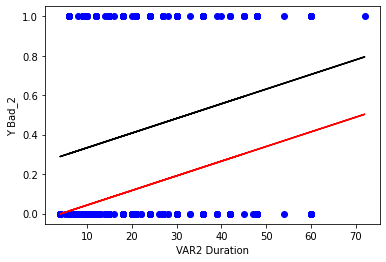

In [7]:
# Let us plot the predictions against the actual y-values
#Make a scatter plot of the y and x1
x_plot = credit[['VAR2']]
y_plot = credit[['Bad_2']]
plt.scatter(x_plot, y_plot, color = 'blue')
plt.ylabel('Y Bad_2')
plt.xlabel('VAR2 Duration')

#Add the regression line for those without a checking account Var1_A14=0
plt.plot(x_plot, linreg.params[0] + linreg.params[2]*x_plot, color = 'black')

#Add the regression line for those with a checking account Var1_A14=1 (params[1])
plt.plot(x_plot, linreg.params[0] + linreg.params[2]*x_plot + linreg.params[1], color = 'red')
plt.show()

The chart shows the blue dots for different values of Duration, but they form two lines: Goods (Y=0) and Bads (Y=1).

Our fitted regression tries to impose a linear model on the non-linear relationship. Not only does it create a problem with predictions going beyond (0,1), but there are serious violations of OLS assumptions that are evident without any residual diagnostics. This means that we cannot say that our model adequately describes the data.

We need the link function to connect both left- and right- hand sides. Logit transformation achieves this.

In [11]:
# Let us plot the logit transformation 
# We start with P(Y=1) values between 0 and 1 in deciles
P = np.array([0.01,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.99])

#Then transform Probability to Odds, removing the upper bound
Odds = P/(1-P)
# And finally take the natural logarithm of odds, removing the lower bound
Log_odds = np.log(Odds)
np.around(np.vstack((P, Odds, Log_odds)), 1)


array([[ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ],
       [ 0. ,  0.1,  0.2,  0.4,  0.7,  1. ,  1.5,  2.3,  4. ,  9. , 99. ],
       [-4.6, -2.2, -1.4, -0.8, -0.4,  0. ,  0.4,  0.8,  1.4,  2.2,  4.6]])

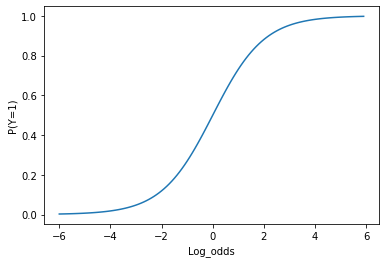

In [12]:
# for a smoother continuous version and going backwards from Log-odds to P
import math

def sigmoid(Log_odds):
    P = []
    for item in Log_odds:
        P.append(1/(1+math.exp(-item))) # here we recover P from log-odds
    return P

Log_odds = np.arange(-6,6,0.1)
sig = sigmoid(Log_odds)

plt.plot(Log_odds,sig)
plt.ylabel('P(Y=1)')
plt.xlabel('Log_odds')
plt.show()


This is a widely used sigmoid curve resulting from the logit transformation of the probability.

In [13]:
# Let us fit logistic regression to the same variables
# We will use the glm() function from the formula submodule of (statsmodels).
import statsmodels.formula.api as smf


# We can define our equation in advnace
formula = 'Bad_2 ~ VAR1_A14+VAR2'

logreg = smf.glm(formula=formula, data=credit, family=sm.families.Binomial()).fit()
print(logreg.params)

#The predict() function can be used to generate predicted probabilities
prob1 = logreg.predict(credit[['VAR1_A14', 'VAR2']])
print(prob1.describe())

Intercept   -1.147967
VAR1_A14    -1.701929
VAR2         0.037755
dtype: float64
count    1000.000000
mean        0.300000
std         0.174752
min         0.063040
25%         0.125233
50%         0.332941
75%         0.439829
max         0.827836
dtype: float64


The predicted probability is now within the boundaries. We can verify this by plotting the prediction against the actual y-values.

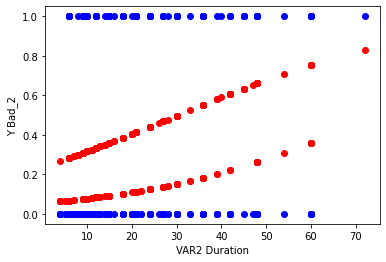

In [18]:
x_plot = credit[['VAR2']]
y_plot = credit[['Bad_2']]
y_plot1 = prob1
plt.scatter(x_plot, y_plot, color = 'blue')
plt.ylabel('Y Bad_2')
plt.xlabel('VAR2 Duration')
plt.scatter(x_plot, y_plot1, color = 'red')
plt.show()

Red dots correspond to the predicted probability of being Bad for values of 'Duration' given in the dataset. The upper curve is for those customers with a checking account Var1_A14=0, and the lower one is for those without it Var1_A14=1. Both are not exactly the same as the nice sigmoid curve shown above, but they correspond to the limited range of 'Duration' variable. An important point is that they do not cross 0 or 1.